In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics # for the evaluation

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
import seaborn as sns
import os
import random

# Control vs Patient: PASSIVE

In [2]:
# model tuning parameters
n_splits = 2
criterion = 'roc_auc'

In [3]:
df = pd.read_csv('../../data/final_dataset.csv')

In [4]:
df['Diagnosis'].unique()

array(['Bipolar II', 'Major Depressive Disorder', 'Bipolar I', 'Control',
       'MDD'], dtype=object)

In [5]:
df['Group'] = df['Diagnosis']
df['Group'] = df['Group'].replace('Bipolar I',1)
df['Group'] = df['Group'].replace('Bipolar II',1)
df['Group'] = df['Group'].replace('MDD',1)
df['Group'] = df['Group'].replace('Major Depressive Disorder',1)
df['Group'] = df['Group'].replace('Control',0)
df.columns

Index(['Unnamed: 0', 'Watch Status', 'Phone Brand', 'Diagnosis', 'Gender',
       'Study ID', 'LAMP ID', 'Race', 'Age', 'DOB', 'Date of Consent',
       'gps_data_quality_mean', 'gps_data_quality_var', 'hometime_mean',
       'hometime_var', 'entropy_mean', 'entropy_var', 'screen_duration_mean',
       'screen_duration_var', 'internal_sleep_mean', 'internal_sleep_var',
       'PHQ-2_mean', 'PHQ-2_var', 'GAD-2_mean', 'GAD-2_var', 'Group'],
      dtype='object')

In [6]:
# predictor and target vars
X = df[['gps_data_quality_mean', 'gps_data_quality_var',
  'hometime_mean', 'hometime_var', 'entropy_mean',
       'entropy_var', 'internal_sleep_mean', 'internal_sleep_var', 'screen_duration_mean',
     'screen_duration_var']]
y = df['Group']

In [7]:
pct_imputed = (X.isnull().sum().sum())/(np.shape(X)[0]*np.shape(X)[1])
print("We have imputed %0.1f percent of the data" % (pct_imputed * 100))

We have imputed 14.9 percent of the data


In [8]:
# train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.5, random_state=0)
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_test.mean())

In [9]:
# standardize
scale_train = StandardScaler()
scale_test = StandardScaler()

X_train = scale_train.fit_transform(X_train)
X_test = scale_test.fit_transform(X_test)

In [10]:
models = {}

# Logistic Regression
from sklearn.linear_model import LogisticRegression
models['Logistic Regression'] = LogisticRegression()

# Support Vector Machines
from sklearn.svm import LinearSVC
models['Support Vector Machines'] = LinearSVC()

# Decision Trees
from sklearn.tree import DecisionTreeClassifier
models['Decision Trees'] = DecisionTreeClassifier()

# Random Forest
from sklearn.ensemble import RandomForestClassifier
models['Random Forest'] = RandomForestClassifier()

# Naive Bayes
from sklearn.naive_bayes import GaussianNB
models['Naive Bayes'] = GaussianNB()

# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
models['K-Nearest Neighbor'] = KNeighborsClassifier()

In [11]:
accuracy, precision, recall, auc = {}, {}, {}, {}

for key in models.keys():
    
    # Fit the classifier
    models[key].fit(X_train, y_train)
    
    # Make predictions
    predictions = models[key].predict(X_test)
    
    # Calculate metrics
    accuracy[key] = accuracy_score(y_test, predictions)
    precision[key] = precision_score(y_test, predictions)
    recall[key] = recall_score(y_test, predictions)
    auc[key] = roc_auc_score(y_test, predictions)

In [12]:
df_model = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'Precision', 'Recall'])
df_model['Accuracy'] = accuracy.values()
df_model['Precision'] = precision.values()
df_model['Recall'] = recall.values()
df_model['AUC'] = auc.values()

In [13]:
df_model

,Accuracy,Precision,Recall,AUC
Logistic Regression,0.615385,0.676471,0.851852,0.467593
Support Vector Machines,0.589744,0.666667,0.814815,0.449074
Decision Trees,0.666667,0.733333,0.814815,0.574074
Random Forest,0.666667,0.684211,0.962963,0.481481
Naive Bayes,0.641026,0.709677,0.814815,0.532407
K-Nearest Neighbor,0.615385,0.676471,0.851852,0.467593


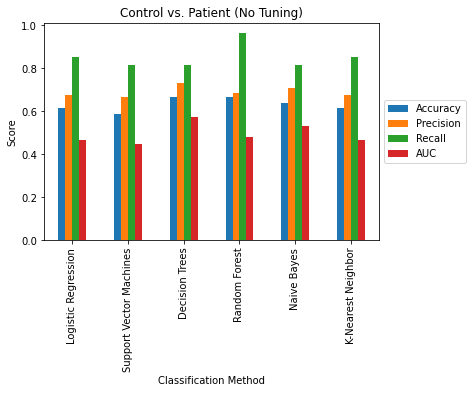

In [14]:
df_model.plot(kind="bar")
plt.title("Control vs. Patient (No Tuning)")
plt.xlabel("Classification Method")
plt.ylabel("Score")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Logistic Regression

In [15]:
# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring=criterion,error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
params = grid_search.best_params_

Best: 0.478968 using {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}
0.332540 (0.143311) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.332540 (0.143311) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.332540 (0.139299) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.369444 (0.146284) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.369444 (0.146284) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.360714 (0.146764) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.437698 (0.175881) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.437698 (0.175881) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.424206 (0.171232) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.475794 (0.174642) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.475794 (0.174642) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.442857 (0.177158) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.478968 (0.175903) wi

In [16]:
# instantiate the model (using tuned params)
logreg_tuned = LogisticRegression(C=params['C'], penalty=params['penalty'], solver=params['solver'])

# fit the model with data
logreg_tuned.fit(X_train, y_train)

y_pred = logreg_tuned.predict(X_test)

In [17]:
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[ 0, 12],
       [ 0, 27]])

Text(0.5, 257.44, 'Predicted label')

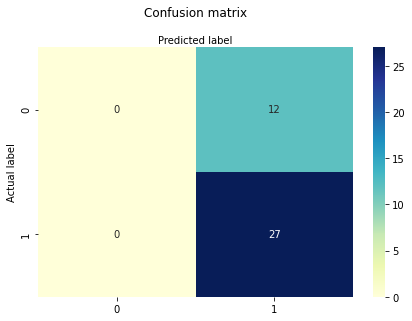

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


In [19]:
print(f'Logistic Regression Model Acccuracy (Tuned Using Optimal Params): {np.trace(cnf_matrix)/np.sum(cnf_matrix)}')

Logistic Regression Model Acccuracy (Tuned Using Optimal Params): 0.6923076923076923


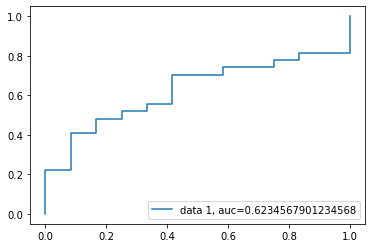

In [20]:
y_pred_proba = logreg_tuned.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

## Support Vector Machines

In [21]:
# define model and parameters
model = LinearSVC()
penalty = ['l2']
loss=['squared_hinge']
dual=[True, False]
C = [10, 1.0, 0.1, 0.01]

# define grid search
grid = dict(penalty=penalty, loss=loss, dual=dual, C=C)
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring=criterion,error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.445635 using {'C': 0.01, 'dual': True, 'loss': 'squared_hinge', 'penalty': 'l2'}
0.335714 (0.145088) with: {'C': 10, 'dual': True, 'loss': 'squared_hinge', 'penalty': 'l2'}
0.335714 (0.145088) with: {'C': 10, 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l2'}
0.364286 (0.156986) with: {'C': 1.0, 'dual': True, 'loss': 'squared_hinge', 'penalty': 'l2'}
0.364286 (0.156986) with: {'C': 1.0, 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l2'}
0.421825 (0.170153) with: {'C': 0.1, 'dual': True, 'loss': 'squared_hinge', 'penalty': 'l2'}
0.421825 (0.170153) with: {'C': 0.1, 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l2'}
0.445635 (0.173087) with: {'C': 0.01, 'dual': True, 'loss': 'squared_hinge', 'penalty': 'l2'}
0.445635 (0.173087) with: {'C': 0.01, 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l2'}


In [22]:
params = grid_search.best_params_

In [23]:
linSVC_tuned = LinearSVC(C=params['C'], dual=params['dual'], loss=params['loss'])

In [24]:
# fit the model with data
linSVC_tuned.fit(X_train, y_train)

y_pred = linSVC_tuned.predict(X_test)

In [25]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[ 0, 12],
       [ 4, 23]])

In [26]:
print(f'Linear SVM Acccuracy (Tuned Using Optimal Params): {np.trace(cnf_matrix)/np.sum(cnf_matrix)}')

Linear SVM Acccuracy (Tuned Using Optimal Params): 0.5897435897435898


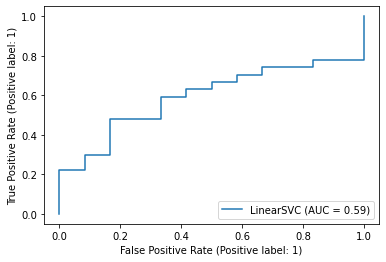

In [27]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(linSVC_tuned,X_test,y_test)

Text(0.5, 257.44, 'Predicted label')

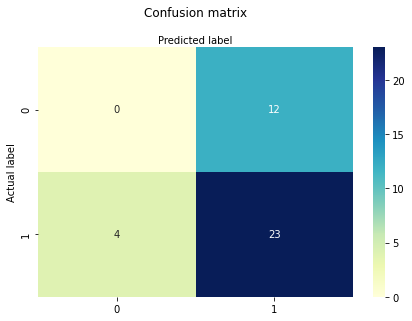

In [28]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')



## Decision Trees

In [29]:
model = DecisionTreeClassifier()
splitter = ['best', 'random']
min_samples_split = range(1, 5) #41
min_samples_leaf = range(1, 5) #21
max_features = [None, 'auto', 'sqrt', 'log2']
presort = [True, False]
# define grid search
grid = dict(splitter=splitter, min_samples_split=min_samples_split, 
            min_samples_leaf=min_samples_leaf,
            max_features=max_features)
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring=criterion,error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.633333 using {'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'splitter': 'random'}
0.000000 (0.000000) with: {'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 1, 'splitter': 'best'}
0.000000 (0.000000) with: {'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 1, 'splitter': 'random'}
0.496825 (0.098397) with: {'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
0.488492 (0.169547) with: {'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}
0.492063 (0.087694) with: {'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 3, 'splitter': 'best'}
0.432937 (0.110635) with: {'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 3, 'splitter': 'random'}
0.486111 (0.096455) with: {'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 4, 'splitter': 'best'}
0.503175 (0.109969) with: {'max_features': None, 'min_samples_leaf': 

In [30]:
params = grid_search.best_params_

In [31]:
# instantiate the model (using tuned params)
decTree_tuned = DecisionTreeClassifier(max_features=params['max_features'], 
                                       min_samples_leaf=params['min_samples_leaf'], 
                                       min_samples_split=params['min_samples_split'],
                                      splitter=params['splitter'])



# fit the model with data
decTree_tuned.fit(X_train, y_train)

y_pred = decTree_tuned.predict(X_test)
y_pred_proba = decTree_tuned.predict_proba(X_test)

In [32]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[ 1, 11],
       [ 5, 22]])

In [33]:
print(f'Decision Trees Acccuracy (Tuned Using Optimal Params): {np.trace(cnf_matrix)/np.sum(cnf_matrix)}')

Decision Trees Acccuracy (Tuned Using Optimal Params): 0.5897435897435898


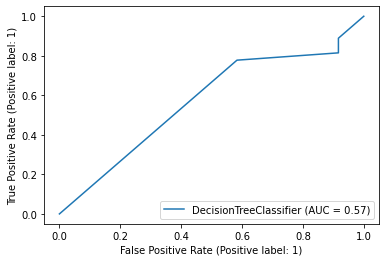

In [34]:
plot_roc_curve(decTree_tuned,X_test,y_test)

Text(0.5, 257.44, 'Predicted label')

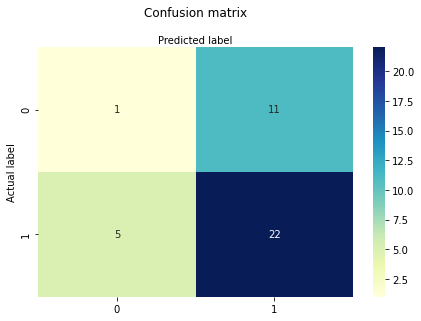

In [35]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

## Random Forest

In [36]:
model = RandomForestClassifier()

max_depth= [80, 90, 100, 110]
max_features = [2, 3]
min_samples_leaf = [3, 4, 5]
min_samples_split = [8, 10, 12]
n_estimators = [100, 200, 300, 1000]
# define grid search
grid = dict(max_depth=max_depth, max_features=max_features, min_samples_leaf=min_samples_leaf,
           min_samples_split=min_samples_split, n_estimators=n_estimators)
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring=criterion,error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.526190 using {'max_depth': 110, 'max_features': 3, 'min_samples_leaf': 5, 'min_samples_split': 12, 'n_estimators': 100}
0.431746 (0.141392) with: {'max_depth': 80, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 100}
0.458333 (0.142292) with: {'max_depth': 80, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 200}
0.468254 (0.159237) with: {'max_depth': 80, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 300}
0.444444 (0.142789) with: {'max_depth': 80, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 1000}
0.465079 (0.113036) with: {'max_depth': 80, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 100}
0.467857 (0.154608) with: {'max_depth': 80, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 200}
0.449603 (0.134956) with: {'max_depth': 80, 'max_features': 2, 'min_samples_leaf': 

In [37]:
params = grid_search.best_params_


In [38]:
# instantiate the model (using tuned params)
ranForest_tuned = RandomForestClassifier(max_features=params['max_features'],
                                         min_samples_leaf=params['min_samples_leaf'], 
                                         min_samples_split=params['min_samples_split'],
                                     max_depth=params['max_depth'], n_estimators=params['n_estimators'])

# fit the model with data
ranForest_tuned.fit(X_train, y_train)

y_pred = ranForest_tuned.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print(f'Random Forest Acccuracy (Tuned Using Optimal Params): {np.trace(cnf_matrix)/np.sum(cnf_matrix)}')

Random Forest Acccuracy (Tuned Using Optimal Params): 0.6923076923076923


Text(0.5, 257.44, 'Predicted label')

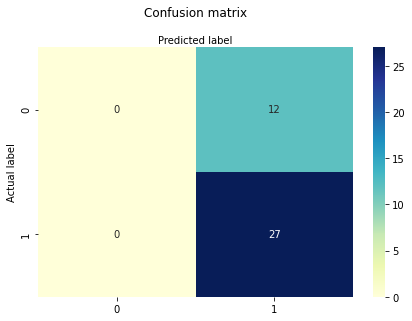

In [39]:

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')



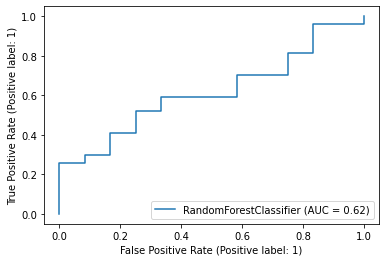

In [40]:
from sklearn.metrics import plot_roc_curve


plot_roc_curve(ranForest_tuned,X_test,y_test)

## Naive Bayes

In [41]:
model = GaussianNB()

params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=params_NB, cv=cv, scoring=criterion, error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.669841 using {'var_smoothing': 0.012328467394420659}
0.537302 (0.120473) with: {'var_smoothing': 1.0}
0.553968 (0.107922) with: {'var_smoothing': 0.8111308307896871}
0.561508 (0.113209) with: {'var_smoothing': 0.657933224657568}
0.569841 (0.116413) with: {'var_smoothing': 0.533669923120631}
0.583333 (0.117835) with: {'var_smoothing': 0.43287612810830584}
0.609921 (0.107666) with: {'var_smoothing': 0.3511191734215131}
0.615873 (0.112407) with: {'var_smoothing': 0.2848035868435802}
0.622222 (0.107466) with: {'var_smoothing': 0.23101297000831597}
0.625794 (0.123927) with: {'var_smoothing': 0.1873817422860384}
0.629762 (0.123456) with: {'var_smoothing': 0.15199110829529336}
0.636111 (0.121401) with: {'var_smoothing': 0.12328467394420659}
0.636111 (0.116248) with: {'var_smoothing': 0.1}
0.642460 (0.116654) with: {'var_smoothing': 0.08111308307896872}
0.644444 (0.121884) with: {'var_smoothing': 0.0657933224657568}
0.646825 (0.123080) with: {'var_smoothing': 0.0533669923120631}
0.6488

In [42]:
params = grid_search.best_params_

In [43]:
nb_tuned = GaussianNB(var_smoothing =  params['var_smoothing'])
# fit the model with data
nb_tuned.fit(X_train, y_train)

y_pred = nb_tuned.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[ 3,  9],
       [ 6, 21]])

In [44]:
print(f'Gaussian Naive Bayes Acccuracy (Tuned Using Optimal Params): {np.trace(cnf_matrix)/np.sum(cnf_matrix)}')

Gaussian Naive Bayes Acccuracy (Tuned Using Optimal Params): 0.6153846153846154


In [45]:
roc_auc_score(y_test, y_pred)

0.5138888888888888

Text(0.5, 257.44, 'Predicted label')

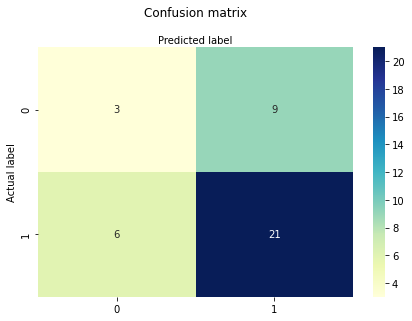

In [46]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')



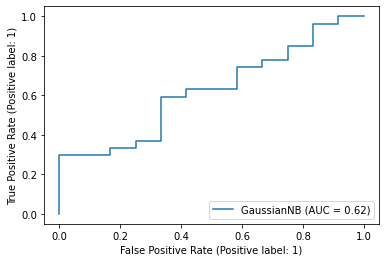

In [47]:
plot_roc_curve(nb_tuned,X_test,y_test)

## KNN Classifier

In [48]:
model = KNeighborsClassifier()

leaf_size = list(range(0,15))
n_neighbors = list(range(0,15))
p=[1,2,3]

# define grid search
grid = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring=criterion,error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.607341 using {'leaf_size': 1, 'n_neighbors': 3, 'p': 3}
0.000000 (0.000000) with: {'leaf_size': 0, 'n_neighbors': 0, 'p': 1}
0.000000 (0.000000) with: {'leaf_size': 0, 'n_neighbors': 0, 'p': 2}
0.000000 (0.000000) with: {'leaf_size': 0, 'n_neighbors': 0, 'p': 3}
0.000000 (0.000000) with: {'leaf_size': 0, 'n_neighbors': 1, 'p': 1}
0.000000 (0.000000) with: {'leaf_size': 0, 'n_neighbors': 1, 'p': 2}
0.000000 (0.000000) with: {'leaf_size': 0, 'n_neighbors': 1, 'p': 3}
0.000000 (0.000000) with: {'leaf_size': 0, 'n_neighbors': 2, 'p': 1}
0.000000 (0.000000) with: {'leaf_size': 0, 'n_neighbors': 2, 'p': 2}
0.000000 (0.000000) with: {'leaf_size': 0, 'n_neighbors': 2, 'p': 3}
0.000000 (0.000000) with: {'leaf_size': 0, 'n_neighbors': 3, 'p': 1}
0.000000 (0.000000) with: {'leaf_size': 0, 'n_neighbors': 3, 'p': 2}
0.000000 (0.000000) with: {'leaf_size': 0, 'n_neighbors': 3, 'p': 3}
0.000000 (0.000000) with: {'leaf_size': 0, 'n_neighbors': 4, 'p': 1}
0.000000 (0.000000) with: {'leaf_size':

In [49]:
params = grid_search.best_params_

In [50]:
knn_tuned = KNeighborsClassifier(leaf_size=params['leaf_size'], 
                                 n_neighbors=params['n_neighbors'], 
                                p=params['p'])
# fit the model with data
knn_tuned.fit(X_train, y_train)

y_pred = knn_tuned.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[ 3,  9],
       [ 4, 23]])

In [51]:
print(f'KNN Classifier Acccuracy (Tuned Using Optimal Params): {np.trace(cnf_matrix)/np.sum(cnf_matrix)}')

KNN Classifier Acccuracy (Tuned Using Optimal Params): 0.6666666666666666


Text(0.5, 257.44, 'Predicted label')

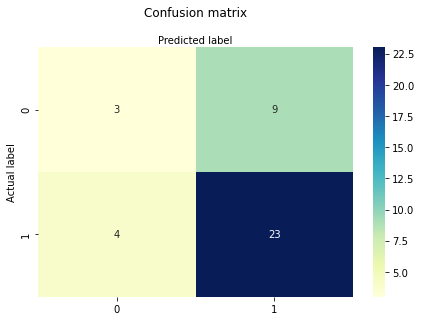

In [52]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')



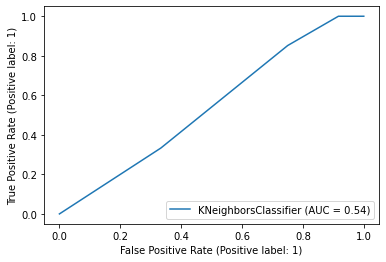

In [53]:
plot_roc_curve(knn_tuned,X_test,y_test)